In [9]:
import sys
import math
import datetime
from pathlib import Path

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Add parent directory to path to import local modules
sys.path.append(str(Path("..").resolve()))
from hyper_rbm import load_model

models_dir = Path("models")
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device}")
print(f"Looking for models in: {models_dir}")

Running on: cpu
Looking for models in: models


In [10]:
import torch
import math

def metropolis_transition_overlap(samples: torch.Tensor,
                                  k: int,
                                  scorer: callable,
                                  n_steps: int = 20,
                                  global_flip_prob: float = 0.5):
    """
    Evolves samples to sample from the OVERLAP distribution P_k.

    Includes Global Spin Flips to resolve sector locking (ferromagnetic ordering).
    Without global flips, chains get stuck in opposite magnetization sectors
    (e.g., All-Up vs All-Down), making the overlap probability ~0.
    """
    if n_steps <= 0: return samples

    batch_size, num_v = samples.shape
    half = batch_size // 2
    device = samples.device

    current_samples = samples.clone()

    # --- Helper to compute total score efficiently ---
    # Total Score = Score_Clean(v1, v2) + Score_Twisted(v1, v2, k)
    def get_total_score(s):
        c1, c2 = s[:half], s[half:]

        # Clean Score (Standard RBM probability)
        log_psi_clean = scorer(torch.cat([c1, c2], dim=0))
        score_clean = log_psi_clean[:half] + log_psi_clean[half:]

        # Twisted Score (Probability with k swaps)
        t1, t2 = c1.clone(), c2.clone()
        if k > 0:
            tmp = t1[:, :k].clone()
            t1[:, :k] = t2[:, :k]
            t2[:, :k] = tmp

        log_psi_twisted = scorer(torch.cat([t1, t2], dim=0))
        score_twisted = log_psi_twisted[:half] + log_psi_twisted[half:]

        return score_clean + score_twisted

    current_total_score = get_total_score(current_samples)
    row_indices = torch.arange(batch_size, device=device)

    for _ in range(n_steps):
        # --- 1. Proposal (Mix of Local and Global moves) ---
        is_global = torch.rand(1, device=device).item() < global_flip_prob

        proposal = current_samples.clone()

        if is_global:
            # Global Flip: Flip entire chains
            # We select chains to flip independently with 50% probability
            flip_mask = torch.rand(batch_size, device=device) < 0.5
            proposal[flip_mask] = 1.0 - proposal[flip_mask]
        else:
            # Local Flip: Standard single spin flip
            flip_indices = torch.randint(0, num_v, (batch_size,), device=device)
            proposal[row_indices, flip_indices] = 1.0 - proposal[row_indices, flip_indices]

        # --- 2. Evaluation ---
        prop_total_score = get_total_score(proposal)

        # --- 3. Acceptance ---
        log_alpha = prop_total_score - current_total_score
        log_uniform = torch.log(torch.rand(half, device=device))

        # Accept if log_unif < log_alpha
        accept_mask = log_uniform < log_alpha

        # Update
        full_mask = torch.cat([accept_mask, accept_mask], dim=0)
        current_samples[full_mask] = proposal[full_mask]
        current_total_score[accept_mask] = prop_total_score[accept_mask]

    return current_samples

def estimate_improved_ratio_overlap(init_samples: torch.Tensor,
                                    max_l: int,
                                    scorer: callable,
                                    steps_per_k: int = 40) -> dict:
    results = {}
    samples = init_samples.clone()
    batch_size = samples.shape[0]
    half = batch_size // 2

    entropy_accum = 0.0
    var_accum = 0.0

    for k in range(max_l):
        # 1. Evolve to P_k
        # This aligns the replicas in the region 0..k
        samples = metropolis_transition_overlap(samples, k, scorer, n_steps=steps_per_k)

        # 2. Measure Ratio R = P_{k+1} / P_k
        c1, c2 = samples[:half].clone(), samples[half:].clone()

        # Denominator: Score with twist k
        t1_d, t2_d = c1.clone(), c2.clone()
        if k > 0:
            t1_d[:, :k], t2_d[:, :k] = t2_d[:, :k].clone(), t1_d[:, :k].clone()

        score_denom_raw = scorer(torch.cat([t1_d, t2_d]))
        score_denom = score_denom_raw[:half] + score_denom_raw[half:]

        # Numerator: Score with twist k+1
        # Apply the EXTRA swap at index k
        t1_n, t2_n = t1_d.clone(), t2_d.clone()
        t1_n[:, k], t2_n[:, k] = t2_n[:, k].clone(), t1_n[:, k].clone()

        score_num_raw = scorer(torch.cat([t1_n, t2_n]))
        score_num = score_num_raw[:half] + score_num_raw[half:]

        # Log Ratio
        # The 'clean' parts of P_{k+1} and P_k cancel out exactly.
        log_ratios = score_num - score_denom

        # 3. Accumulate
        # Use log-sum-exp trick for numerical stability of the mean
        max_log = torch.max(log_ratios)
        mean_r = torch.exp(max_log) * torch.mean(torch.exp(log_ratios - max_log))

        step_s2 = -torch.log(mean_r).item()
        entropy_accum += step_s2

        # Error propagation (standard error of the mean)
        var_r = torch.var(torch.exp(log_ratios))
        step_err_sq = (var_r / (mean_r**2) / half).item()
        var_accum += step_err_sq

        results[k+1] = (entropy_accum, math.sqrt(var_accum))

    return results

In [11]:
# UPDATE THIS FILENAME to your actual model file
model_filename = "hyprbm_tfim_16_20000_20260118_193918.pt"
model_path = models_dir / model_filename

print(f"Loading checkpoint: {model_path.name}")

model, config = load_model(model_path, device)

CHAIN_LENGTH = int(model.num_v)
h_support_vals = sorted(config.get("h_support", []))
print(f"Trained on support points: {h_support_vals} \n")

ref_file = Path(f"tfim_{CHAIN_LENGTH}_entangle_ref.csv")
try:
    ref_df = pd.read_csv(ref_file)
    print(f"Loaded ED reference data from: {ref_file.name}")
except FileNotFoundError:
    ref_df = None
    print("Reference file not found, skipping comparison.")

Loading checkpoint: hyprbm_tfim_16_20000_20260118_193918.pt
Trained on support points: [0.5, 0.8, 0.95, 1.0, 1.05, 1.2, 1.5] 

Loaded ED reference data from: tfim_16_entangle_ref.csv


In [ ]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

INITIAL_BURN_IN = 100
TOTAL_SAMPLES = 100_000
TRANSITION_STEPS = 100

DENSE_RES = 0.05

# Define scan range
h_novel_vals = np.arange(min(h_support_vals), max(h_support_vals) + 0.01, DENSE_RES)
h_novel_vals = [h for h in h_novel_vals if not any(np.isclose(h, s, atol=1e-3) for s in h_support_vals)]
all_h_values = sorted(list(set(h_support_vals) | set(h_novel_vals)))

print(f"Sweeping h: [{min(all_h_values):.2f}, {max(all_h_values):.2f}]")
print(f"Samples: {TOTAL_SAMPLES} | Transition Steps: {TRANSITION_STEPS}")

results_list = []
max_l = CHAIN_LENGTH // 2
l_axis = list(range(1, max_l + 1))

rng_eval = torch.Generator(device=device).manual_seed(SEED)
model_dtype = next(model.parameters()).dtype

for h_val in all_h_values:
    split = "support" if any(np.isclose(h_val, s, atol=1e-3) for s in h_support_vals) else "interpolated"
    print(f"Processing h={h_val:.2f} ({split})...", end="", flush=True)

    cond_batch = torch.full((TOTAL_SAMPLES, 1), h_val, device=device, dtype=model_dtype)
    schedule = torch.tensor([1.0] * INITIAL_BURN_IN, device=device, dtype=model_dtype)

    with torch.no_grad():
        base_samples = model.generate(cond_batch, schedule, rng=rng_eval)

    def scorer(v):
        c = torch.full((v.shape[0], 1), h_val, device=v.device, dtype=v.dtype)
        return model.log_score(v, c)

    chain_results = estimate_improved_ratio_overlap(
        base_samples,
        max_l,
        scorer,
        steps_per_k=TRANSITION_STEPS
    )

    for l, (val, err) in chain_results.items():
        results_list.append({
            "h": float(h_val),
            "l": int(l),
            "s2": val,
            "s2_err": err,
            "type": split
        })
    print(f" Done. (L={max_l} S2={chain_results[max_l][0]:.4f})")

results_df = pd.DataFrame(results_list)

Sweeping h: [0.50, 1.50]
Samples: 100000 | Transition Steps: 100
Processing h=0.50 (support)...

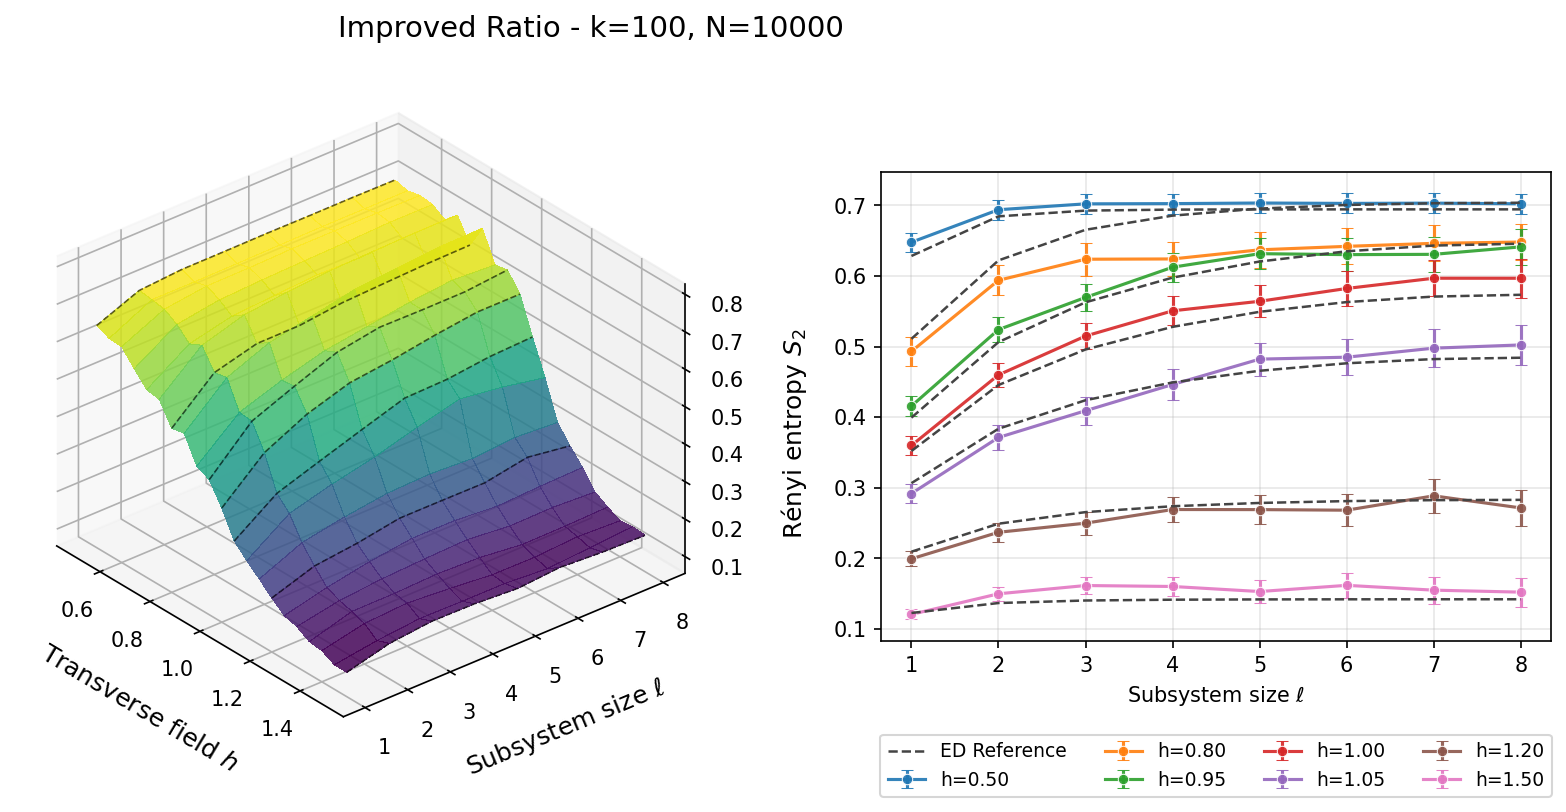

In [20]:
# CONFIGURATION (plot only)
PLOT_WSPACE = -0.15
VERTICAL_OFFSET_2D = 0.02
BOX_ASPECT_2D = 0.7
Z_LABEL_PAD = 9
TITLE_PAD_2D = 20
LEGEND_NCOL = 4
LEGEND_X = 0.5
LEGEND_Y = -0.18

MAX_SURF_COLS = 220
MAX_SURF_ROWS = 80
SURF_SHADE    = False

pivot_df = results_df.pivot(index='l', columns='h', values='s2')
pivot_df = pivot_df.sort_index().sort_index(axis=1)

h_dense  = pivot_df.columns.to_numpy(dtype=float)
l_values = pivot_df.index.to_numpy(dtype=float)

X_h, Y_l = np.meshgrid(h_dense, l_values)
Z_s2 = pivot_df.to_numpy(dtype=float)

support_h_keys = sorted(results_df[results_df['type'] == 'support']['h'].unique())

fig = plt.figure(figsize=(16, 6), dpi=150)
fig.patch.set_facecolor('white')

# --- Main Title ---
fig.suptitle(f"Improved Ratio - k={TRANSITION_STEPS}, N={TOTAL_SAMPLES}", fontsize=14, y=0.95)

gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 0.8], wspace=PLOT_WSPACE)

# --- 3D ---
ax3d = fig.add_subplot(gs[0], projection='3d')
ax3d.set_proj_type('ortho')

step_c = max(1, X_h.shape[1] // MAX_SURF_COLS)
step_r = max(1, X_h.shape[0] // MAX_SURF_ROWS)

Xr = X_h[::step_r, ::step_c]
Yr = Y_l[::step_r, ::step_c]
Zr = Z_s2[::step_r, ::step_c]

surf = ax3d.plot_surface(
    Xr, Yr, Zr,
    cmap='viridis',
    rstride=1, cstride=1,
    shade=SURF_SHADE,
    linewidth=0,
    antialiased=False,
    alpha=0.85
)

ax3d.set_zlim(np.nanmin(Zr) - 0.05, np.nanmax(Zr) + 0.1)
ax3d.set_xlabel("Transverse field $h$", fontsize=12, labelpad=10)
ax3d.set_ylabel("Subsystem size $\\ell$", fontsize=12, labelpad=10)
ax3d.set_zlabel("Rényi entropy $S_2$", fontsize=12, labelpad=Z_LABEL_PAD)
ax3d.view_init(elev=30, azim=-40)

for h in support_h_keys:
    subset = results_df[results_df['h'] == h].sort_values('l')
    ax3d.plot(
        np.full_like(l_values, float(h), dtype=float),
        l_values,
        subset['s2'].to_numpy(dtype=float),
        color='black', linestyle='--', linewidth=0.8, alpha=0.6, zorder=10
    )

# --- 2D ---
ax2d = fig.add_subplot(gs[1])
ax2d.set_box_aspect(BOX_ASPECT_2D)
pos = ax2d.get_position()
ax2d.set_position([pos.x0, pos.y0 + VERTICAL_OFFSET_2D, pos.width, pos.height])

cmap_2d = plt.get_cmap("tab10")

ref_lbl_added = False

for i, h in enumerate(support_h_keys):
    subset = results_df[results_df['h'] == h].sort_values('l')
    s2 = subset['s2'].to_numpy(dtype=float)
    err = subset['s2_err'].to_numpy(dtype=float)
    col = cmap_2d(i % 10)

    if ref_df is not None:
        mask = np.isclose(ref_df["h"], h, atol=1e-3)
        if mask.any():
            l_cols = sorted(
                [c for c in ref_df.columns if c.startswith("l") and int(c[1:]) in l_values],
                key=lambda s: int(s[1:])
            )
            y_ref = ref_df.loc[mask].iloc[0][l_cols].values.astype(float)
            x_ref = [int(c[1:]) for c in l_cols]
            lbl = "ED Reference" if not ref_lbl_added else "_nolegend_"
            ax2d.plot(x_ref, y_ref, '--', color='#444444', linewidth=1.2, label=lbl, zorder=5)
            ref_lbl_added = True

    ax2d.errorbar(
        l_values, s2,
        yerr=err,
        fmt='o-',
        color=col,
        markersize=5,
        linewidth=1.5,
        alpha=0.9,
        markeredgecolor='white',
        markeredgewidth=0.5,
        capsize=3,
        elinewidth=1.5,
        label=f"h={h:.2f}",
        zorder=4
    )

ax2d.set_xlabel("Subsystem size $\\ell$")
ax2d.legend(frameon=True, fontsize=9, loc='upper center',
            bbox_to_anchor=(LEGEND_X, LEGEND_Y), ncol=LEGEND_NCOL)
ax2d.grid(True, alpha=0.3)

plt.show()